#Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LayerNormalization


from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


# Data prepration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = '/content/drive/MyDrive/action_recognition/dataset20.csv'
dataset = pd.read_csv(file_path) #reading the dataset

In [5]:
print(dataset.shape) #checking its shape

(321428, 21)


In [6]:
dataset.head() #taking a look at the dataset

,lastSensorEventHours,lastSensorEventSeconds,windowDuration,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-OutsideDoor,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-DiningRoom,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-OutsideDoor,label
0,-0.439845,-0.407339,-0.283800,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.433035,-0.500411,-0.806492,4.371657,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706324,26
1,-0.439845,-0.407291,-0.282950,-1.545536,-1.545432,1.731450,1.731450,1.465175,-0.455621,-0.510093,1.457228,-0.500411,-0.806492,4.301066,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706652,26
2,-0.439845,-0.401850,-0.189541,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.443221,-0.500411,-0.806492,4.341935,13.780628,15.748974,10.111505,12.958303,18.366668,-0.686144,26
3,-0.439845,-0.401658,-0.186993,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.429215,-0.500411,-0.806492,4.382803,13.780628,15.748974,10.111505,12.958303,18.366668,-0.685372,26
4,-0.439845,-0.401658,-0.187842,-1.545536,-1.545432,1.731450,1.731450,1.465175,-0.455621,-0.510093,1.287872,-0.500411,-0.806492,4.795202,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706652,26


In [7]:
def generate_seqences(dataset): #this function returns our sequences and their labels
  sequences = [] #sequences will be stored in this list
  labels = [] #labels of seaquences will be stored in this list
  time_step = 32 #each seq will include 32 rows of our table
  stride = 1 #number of rows we slide at each iteration
  num_sequences = len(dataset) - time_step + stride
  for i in range(num_sequences):
    start = i #fist index of sequence number i
    end = i + time_step - stride #last index of sequence number i
    sequences.append(dataset.iloc[start:end+1,:-1]) #fetching rows of features
    labels.append(dataset.iloc[end,-1]) #fetching the label of last row in a sequence
  return sequences,labels

In [8]:
sequences,labels = generate_seqences(dataset) #generates a lit of sequences 
sequences= np.stack(sequences) #numpy array of shape (num_sequences,16,21)
labels = np.stack(labels) #numpy array of shape (num_sequences,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.1) #spliting sequences into train and test sets
y_train = to_categorical(y_train) #onehot encoding
y_test = to_categorical(y_test) #onehot encoding

In [10]:
print(f"length of X_train: {X_train.shape}")
print(f"length of y_train: {y_train.shape}")
print(f"length of X_test: {X_test.shape}")
print(f"length of y_test: {y_test.shape}")

length of X_train: (289257, 32, 20)
length of y_train: (289257, 35)
length of X_test: (32140, 32, 20)
length of y_test: (32140, 35)


In [11]:
n_timesteps, n_features, n_outputs =   X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [12]:
print(f"length of X_train: {X_train.shape}")
print(f"length of y_train: {y_train.shape}")
print(f"length of X_test: {X_test.shape}")
print(f"length of y_test: {y_test.shape}")

length of X_train: (289257, 32, 20)
length of y_train: (289257, 35)
length of X_test: (32140, 32, 20)
length of y_test: (32140, 35)


#Defining and training a Bidirectional LSTM model

In [14]:
num_epochs = 30
# define model
model = Sequential()

model.add(Bidirectional(LSTM(200, input_shape=(n_timesteps,n_features) , return_sequences=True))) #the output will have 3 dimensionals
#adding and LSTM layer with 200 neurons
model.add(LayerNormalization())
#adding layer normalization

model.add(Bidirectional(LSTM(200)))
#adding a bidirectional LSTM layer with 200 neurons
model.add(LayerNormalization())
#adding layer normalization

model.add(Dense(100, activation='relu'))
#adding a dense layer with 100 neurons and relu activation
model.add(Dense(n_outputs, activation='softmax'))
#adding a dense layer with 35 neurons and softmax activaion

model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
#compling the model with categorical cross entropy loss function and adam optimizer

start_time = time.time() #start time of training
history = model.fit(X_train, y_train, validation_split=0.05, epochs=num_epochs, batch_size=256) #training the model
print(f'elapsed time: {time.time() - start_time}') #print the time duration of training

Epoch 1/30
1074/1074 [==============================] - 111s 96ms/step - loss: 0.6885 - accuracy: 0.7623 - val_loss: 0.5048 - val_accuracy: 0.8198
Epoch 2/30
1074/1074 [==============================] - 100s 93ms/step - loss: 0.4056 - accuracy: 0.8553 - val_loss: 0.3588 - val_accuracy: 0.8690
Epoch 3/30
1074/1074 [==============================] - 101s 94ms/step - loss: 0.2895 - accuracy: 0.8978 - val_loss: 0.2706 - val_accuracy: 0.9036
Epoch 4/30
1074/1074 [==============================] - 100s 93ms/step - loss: 0.2275 - accuracy: 0.9193 - val_loss: 0.2235 - val_accuracy: 0.9210
Epoch 5/30
1074/1074 [==============================] - 100s 93ms/step - loss: 0.1906 - accuracy: 0.9324 - val_loss: 0.1970 - val_accuracy: 0.9309
Epoch 6/30
1074/1074 [==============================] - 101s 94ms/step - loss: 0.1657 - accuracy: 0.9414 - val_loss: 0.1748 - val_accuracy: 0.9381
Epoch 7/30
1074/1074 [==============================] - 101s 94ms/step - loss: 0.1496 - accuracy: 0.9470 - val_loss: 0

# Results

In [15]:
_ ,accuracy = model.evaluate(X_test, y_test, batch_size=128) #testing the model
print(accuracy)

252/252 [==============================] - 7s 25ms/step - loss: 0.1167 - accuracy: 0.9643
0.9643434882164001


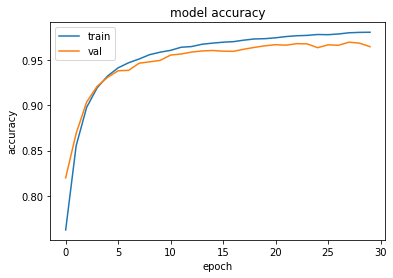

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

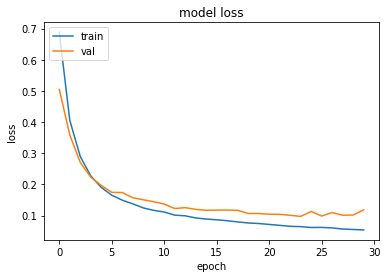

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()